# EEG bandpower

This notebook demonstrates how to use YASA to calculate the spectral bandpower per channel and per sleep stage.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import mne
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.2)

## Data loading

### EEG data

Let's load ~45 min of mid-afternoon nap data (6 channels), sampled at 100 Hz. We use the [MNE library](https://mne.tools/stable/index.html), which includes various functions and utilities for reading EEG data and electrode locations. For a description of all the file formats supported by MNE, please refer to https://mne.tools/stable/manual/io.html#importing-data-from-eeg-devices

Note that during loading, [MNE automatically scale the EEG data from microVolts (uV) to Volts](https://martinos.org/mne/dev/manual/io.html#id3). However, YASA requires the data to be in microVolts (uV), and therefore we need to reverse this scaling by multiplying our data by 1e6 (1 V = 1,000,000 uV).

In [2]:
# Load data as a MNE Raw file
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=0)

# Keep only the EEG channels
raw.pick_types(eeg=True)

# Apply a bandpass filter between 0.5 - 45 Hz
raw.filter(0.5, 45)

# Extract the data and convert from V to uV
data = raw._data * 1e6
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2']
Sampling frequency = 100.0 Hz
Data shape = (6, 294000)


### Hypnogram

Let's now load the corresponding hypnogram (sleep staging) vector. In this case, the hypnogram is a simple text file in which one value represents 30 seconds of EEG data.

The sleep stages are defined according to the [standard guidelines](https://aasm.org/clinical-resources/scoring-manual/):

    W: Wake
    N1: N1 sleep
    N2: N2 sleep
    N3: N3 sleep
    R: REM sleep

In [3]:
hypno = np.loadtxt('sub-02_hypno_30s.txt', dtype=str)
hypno

array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N1', 'W', 'W', 'W',
       'W', 'N1', 'N1', 'N1', 'W', 'W', 'N1', 'N1', 'N1', 'N1', 'N2',
       'N2', 'N2', 'W', 'N1', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'W',
       'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U2')

**Conversion str => int**

Our first step is to convert this text vector into a vector of integers, which is easier to work with. The default mapping is defined below:

    W  => 0
    N1 => 1
    N2 => 2
    N3 => 3
    R  => 4
    
However, you can also apply a custom mapping using the `mapping_dict=` argument of the [hypno_str_to_int](https://htmlpreview.github.io/?https://raw.githubusercontent.com/raphaelvallat/yasa/master/html/hypno.html#yasa.hypno.hypno_str_to_int) function.

In [4]:
hypno_int = yasa.hypno_str_to_int(hypno)
hypno_int

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

**Upsampling**

The last step is to upsample our hypnogram to the sampling frequency of the data. This step is *absolutely critical* and all YASA's function require that the data and hypnogram have the same sampling frequency and shape -- which makes life so much easier to mask and select specific sleep stages.

Fortunately, YASA also provides a convenient function ([hypno_upsample_to_data](https://htmlpreview.github.io/?https://raw.githubusercontent.com/raphaelvallat/yasa/master/html/hypno.html#yasa.hypno.hypno_upsample_to_data)) to automatically upsample and fit the hypnogram to a given sampling frequency and data length.
This function requires the hypnogram and its sampling frequency, as well as the data and its sampling frequency. In our case, the sampling frequency of our hypnogram is 1 / 30 since there is one point per every 30 seconds of data. The sampling frequency of the data is 100 Hz.

Note that if the upsampled hypnogram is shorter or longer than the length of data, a warning will be displayed and the hypnogram will be automatically padded or cropped to exactly match the length of data.

In [5]:
hypno_up = yasa.hypno_upsample_to_data(hypno=hypno_int, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno_up.size == data.shape[1])  # Does the hypnogram have the same number of samples as data?
print(hypno_up.size, 'samples:', hypno_up)

True
294000 samples: [0 0 0 ... 0 0 0]


**************

## Bandpowers in NREM sleep

*For a primer on EEG spectral bandpower please refer to https://raphaelvallat.com/bandpower.html*

Now that we have our data and hypnogram, how can we calculate the spectral bandpowers in, let's say, N2 and N3 sleep (commonly referred to as NREM sleep)?

### Keep only N2 + N3 sleep

Our first step is to apply a masking on the data to only keep samples that are in N2 or N3 sleep. Since our data and hypnogram now have the same sampling frequency and shape, this can be done using a [simple NumPy indexing](https://docs.scipy.org/doc/numpy/reference/generated/numpy.isin.html):

In [6]:
where_NREM = np.isin(hypno_up, [2, 3])  # True if sample is in N2 / N3, False otherwise
data_NREM = data[:, where_NREM]
print(data_NREM.shape)

(6, 159000)


### Calculate Welch's PSD

The gold-standard and most widely-used method to calculate the power spectral density (PSD) of EEG data is the [Welch's sliding periodogram](https://en.wikipedia.org/wiki/Welch%27s_method), which is implemented in [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html).

The Welch's method improves the accuracy of the [classic periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html). The reason is simple: EEG data are always time-varying, meaning that if you look at a 30 seconds of EEG data, it is very (very) unlikely that the signal will looks like a perfect sum of pure sines. Rather, the spectral content of the EEG changes over time, constantly modified by the neuronal activity at play under the scalp. Problem is, to return a true spectral estimate, a classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance. By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution. The frequency resolution in Welch's method is defined by the window length, such that $F = 1 / t$, with $t$ being the window length in seconds. In other words, a 4-sec sliding window will give a frequency resolution of 1 / 4 = 0.25 Hz.

How do we define the optimal window duration then? A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest. So for instance, if our lowest frequency of interest is 1 Hz so we will choose a window of 2 / 1 = 2 seconds.

Note that in the code below, I use a *median average* of all the resulting sliding windows. Indeed, this may result in less biased and more accurate PSD as explained [in this paper](https://www.biorxiv.org/content/10.1101/441626v2).

(201,) (6, 201)


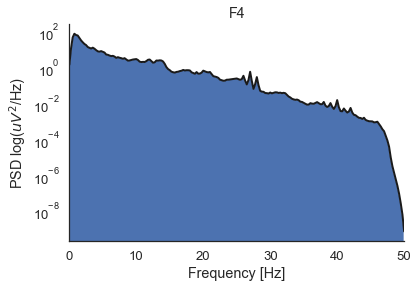

In [7]:
from scipy.signal import welch

win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data_NREM, sf, nperseg=win, average='median')  # Works with single or multi-channel data

print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

# Plot
plt.plot(freqs, psd[1], 'k', lw=2)
plt.fill_between(freqs, psd[1], cmap='Spectral')
plt.xlim(0, 50)
plt.yscale('log')
sns.despine()
plt.title(chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

### Extract bandpower

Now that we have the PSD for each channel, we need to calculate the average power in specified bands. The power in a frequency band is defined by the area under the curve of the non-log-transformed PSD. For more details, please refer to https://raphaelvallat.com/bandpower.html.

Here again, YASA provides a convenient function ([bandpower_from_psd](https://htmlpreview.github.io/?https://raw.githubusercontent.com/raphaelvallat/yasa/master/html/spectral.html#yasa.spectral.bandpower_from_psd)) to extract the average bandpower in specified bands from a pre-computed PSD.

**Relative power**

In [8]:
# Relative power: sum of all (non-overlapping and sequential) bands equals to 1
yasa.bandpower_from_psd(psd, freqs, ch_names=chan)

,Chan,Delta,Theta,Alpha,Beta,Gamma,FreqRes,Relative
0,F3,0.714872,0.166226,0.070516,0.047779,0.000607,0.25,True
1,F4,0.719722,0.140793,0.066615,0.071700,0.001170,0.25,True
2,C3,0.708896,0.151639,0.079097,0.059738,0.000629,0.25,True
3,C4,0.678407,0.137858,0.081388,0.100339,0.002008,0.25,True
4,O1,0.664873,0.151314,0.101223,0.082191,0.000399,0.25,True
5,O2,0.663774,0.157096,0.094293,0.084369,0.000468,0.25,True


**Absolute power**

In [9]:
# Absolute power, using different bands
bp = yasa.bandpower_from_psd(psd, freqs, ch_names=chan, bands=[(1, 12, 'Slow'), (12, 30, 'Beta')], relative=False)
bp

,Chan,Slow,Beta,FreqRes,Relative
0,F3,118.157078,8.211144,0.25,False
1,F4,104.003894,10.667229,0.25,False
2,C3,95.300966,8.068256,0.25,False
3,C4,84.098698,12.264104,0.25,False
4,O1,522.730225,63.275577,0.25,False
5,O2,460.613075,56.541394,0.25,False


In [10]:
# Bonus: see the frequency bands that were used
bp.bands_

"[(1, 12, 'Slow'), (12, 30, 'Beta')]"